# 다음에 볼 영화 예측하기

In [107]:
# 라이브러리 임포트

import pandas as pd
import tensorflow as tf
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [2]:
# 데이터 로드

data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## 1. 데이터 전처리

전 노드에서는 session이 정의되어 있었고, 그렇기 때문에 session_based recommendation을 사용할 수 있었다.

결론부터 말하자면, 우선은 session을 따로 지정해주지 않겠다.

session은 하나의 사용자가 들어와 수행하고 싶은 과정을 수행하고 나갔을 때 종료된다고 볼 수 있다. 물론 시간과 같은 부분을 고려할 수는 있겠지만, 그냥 직관적으로 생각해봤을 때 그렇다는 소리다.

그런데 영화의 평가에 대한 부분이 시간에 따라 변하긴 하겠지만, 10분 전에 내가 제시한 평가에 대한 값이 10분 후의 평가에 대한 값과 대단히 다를 수 없다. 영화를 다시 관람하고 직접 체험해보지 않는 한 이 평가가 순식간에 바뀌기는 쉽지 않다. 따라서, user id 하나, 다시 말해 평가자 한 명당 하나의 세션이라고 간주하고 모델링을 수행하는 것이 합리적일 것으로 판단하였다.

그럼 데이터의 user id의 상태를 한 번 보도록 하자.

In [3]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

<AxesSubplot:ylabel='Count'>

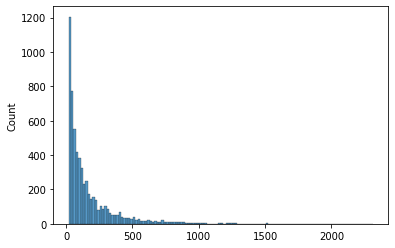

In [4]:
sns.histplot(session_length)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


In [6]:
data.describe()

,UserId,ItemId,Rating,Time
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


user id의 분포는 약 100개 사이에 대부분의 값들이 몰려 있는 것을 볼 수 있다.

결측치는 없고, 특이한 데이터가 보이지는 않는 듯하다.

데이터의 Time 값이 int형이므로, 이를 datetime 형식으로 바꿔주자.

In [164]:
data_df = data.copy()
data_df.Time = pd.to_datetime(data.Time, unit='s')
data_df

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


<AxesSubplot:xlabel='Rating', ylabel='Count'>

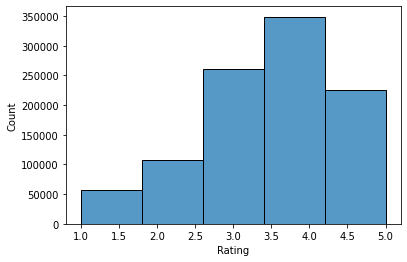

In [165]:
sns.histplot(data_df['Rating'], bins=5)

rating의 분포를 살펴보면, 4점에 가장 많은 값이 있고, 1, 2점은 적은 수인 것을 볼 수 있다.

1점이나 2점을 받은 값들도 추천 대상에 집어넣어야 할까?

우리가 추천을 수행할 때, 낮은 점수가 많은 영화를 사람들이 추천받고 싶을까?

이후에 이 부분도 고려해보도록 하자.

In [166]:
session_length = data_df.groupby('UserId').size()

In [167]:
print(session_length.median(), session_length.mean())
print(session_length.min(), session_length.max())
session_length.quantile(0.999)

96.0 165.5975165562914
20 2314


1343.181000000005

<AxesSubplot:ylabel='Count'>

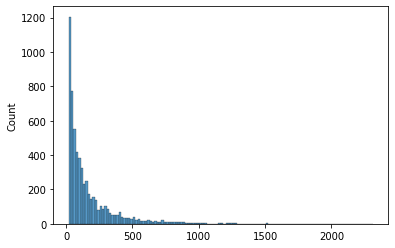

In [168]:
sns.histplot(session_length)

다시 한 번 세션 길이(user id)를 살펴보자. user id별 평가 수행 횟수라고 볼 수 있겠다.

중간값은 96, 평균은 165,
최솟값은 20, 최댓값은 2314이다.

1343건의 평가를 수행한 사람이 전체의 99.9% 안에 속한다.

즉, 그 이상의 값은 평가를 수행한 사람 중에서도 과하게 많은 숫자의 평가를 진행했다고도 볼 수 있다.

그래프를 살펴보면, 거의 보이지는 않지만 2000 이상에도 값이 존재하는 것을 알 수 있고,

최댓값에도 2314가 있으므로 1343 위에 몇 건의 데이터가 있다고 볼 수 있다.

In [169]:
session_length.sort_values().head(10)

UserId
947     20
4068    20
2530    20
341     20
5258    20
4383    20
98      20
4393    20
2061    20
2584    20
dtype: int64

In [170]:
session_length.sort_values().tail(10)

UserId
1015    1286
1150    1302
2063    1323
3618    1344
889     1518
1181    1521
1941    1595
4277    1743
1680    1850
4169    2314
dtype: int64

In [171]:
data_df[data_df.UserId==4169].nunique()

UserId       1
ItemId    2314
Rating       5
Time       684
dtype: int64

In [172]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

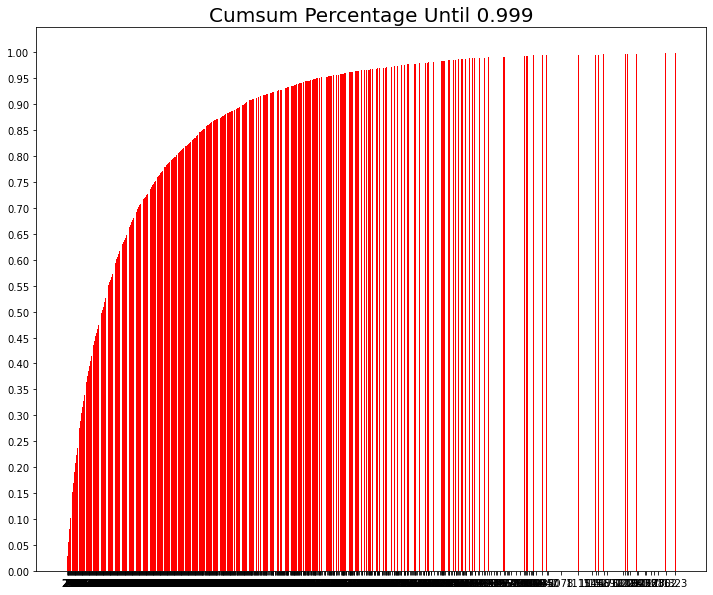

In [173]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

0.999까지의 데이터를 시각화한 것이다.

1343 이상의 값들을 굳이 써야 할까 싶기도 하다.

이 부분도 추후에 고려해보도록 하자.

여러 가지 테스트를 수행해보기 위해, 데이터 셋을 세 개로 나누려고 한다.

data_df는 원본 데이터,

data_df_r은 rating 값이 3 이상인 데이터,

data_df_cl은 rating 값이 3 이상이면서 1343건 이하의 session length를 가진 데이터라고 보면 된다.

In [174]:
data_df_cl = data_df.copy()

In [175]:
for i in session_length[session_length > 1344].index:
    data_df_cl = data_df_cl[data_df.UserId!=i]

In [176]:
session_length = data_df_cl.groupby('UserId').size()
session_length.max()

1344

In [177]:
data_df_r = data_df[data_df.Rating >= 3]

In [178]:
data_df_cl = data_df_cl[data_df_cl.Rating >= 3]

전 노드에서는 세션의 길이를 가지고 재귀적으로 데이터 정제를 수행했지만, 이번 데이터셋의 경우에는 기본적으로 사람들이 최소 20건 이상의 평가를 수행했다고 데이터 설명에 나와 있고, 우리도 그 부분을 확인했으므로 추가적인 정제는 여기까지 하겠다.

그리고 시간 데이터를 잠깐 살펴보도록 하자.

In [179]:
datetime_value = pd.to_datetime(data.Time, unit='s')
datetime_value

31        2000-12-31 22:00:19
22        2000-12-31 22:00:55
27        2000-12-31 22:00:55
37        2000-12-31 22:00:55
24        2000-12-31 22:01:43
                  ...        
1000019   2001-08-10 14:40:29
999988    2001-08-10 14:41:04
1000172   2001-08-10 14:41:04
1000167   2001-08-10 14:41:26
1000042   2001-08-20 13:44:15
Name: Time, Length: 1000209, dtype: datetime64[ns]

In [180]:
datetime_value.max(), datetime_value.min()

(Timestamp('2003-02-28 17:49:50'), Timestamp('2000-04-25 23:05:32'))

2000년 4월 25일부터 2003년 2월 28일까지의 데이터를 가지고 있다.

In [181]:
data_df[data_df.Time == datetime_value.max()] 

,UserId,ItemId,Rating,Time
825603,4958,1924,4,2003-02-28 17:49:50


In [182]:
year_counts = data_df['Time'].dt.year.value_counts().sort_index()
year_counts = pd.DataFrame(year_counts).reset_index()
year_counts

,index,Time
0,2000,904757
1,2001,68058
2,2002,24046
3,2003,3348


In [183]:
year_counts = data_df['Time'].dt.year.value_counts().sort_index()
year_counts = pd.DataFrame(year_counts).reset_index()
year_counts

,index,Time
0,2000,904757
1,2001,68058
2,2002,24046
3,2003,3348


<AxesSubplot:xlabel='index', ylabel='Time'>

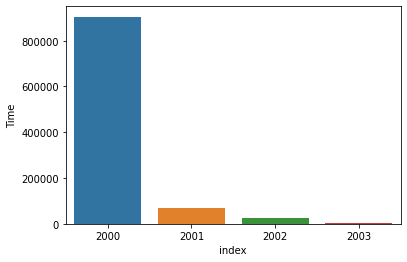

In [184]:
sns.barplot(year_counts['index'], year_counts.Time)

데이터의 분포를 보면, 2000년이 가장 많고, 2001, 2002, 2003년 순으로 볼 수 있다.

2000년의 데이터를 학습, 2001년의 데이터를 검증, 2002, 2003년의 데이터를 평가 데이터로 사용하자.

이 부분도 크게 문제가 있다고 생각하긴 한다.

2000년과 2001년에 평가가 수행된 데이터를 가지고 2002년과 2003년에 평가를 수행한다는 개념 자체가 어불성설이다.

2002년과 2003년에 개봉된(물론 그 이전의 아이템에 대한 평가도 해당 기간에 수행할 수 있겠지만) 영화에 대한 평가 정보는 해당 모델이 담지 못할 것이 분명하며, 그 부분은 다음에 제시할 indexing 함수에서도 잘 드러난다.

indexing 함수의 효과는 training set에 존재하는 기준을 따라 val 및 test set에도 같은 인덱싱을 적용하는 것이다.

이는 새로 생성될 데이터에 대한 평가를 수행하지 못한다는 한계가 있다.

그렇다고 시계열 데이터가 아닌 데이터를 모델링할 때처럼 무작위로 train test split을 수행한다면, 평가의 의미가 사라진다.

어차피 우리가 실제로 이 모델을 사용한다고 가정한다면, 이 모델이 받아야 할 데이터는 최소 2003년 2월 28일 이후의 데이터일 것이다.

따라서, 우리는 추가적으로 test가 주어져 있지 않다고 가정하고 2000년과 2001년을 학습 검증 데이터로 활용하는 것이 이 모델이 과거의 데이터를 가지고 현재를 예측하는 것이 가능한가에 대한 대답을 찾기 위해 더 효과적이라고 볼 수 있을 것이다.

In [186]:
def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    return df

def split_data(data):
    train_set = data[data.Time.dt.year == 2000]
    valid_set = data[data.Time.dt.year == 2001]
    test_set = data[(data.Time.dt.year == 2002) | (data.Time.dt.year == 2003)]
    
    id2idx = {item_id : index for index, item_id in enumerate(train_set['ItemId'].unique())}
    train_set = indexing(train_set, id2idx)
    valid_set = indexing(valid_set, id2idx)
    test_set = indexing(test_set, id2idx)
    
    return train_set, valid_set, test_set

In [187]:
tr, val, test = split_data(data_df)

In [188]:
tr_r, val_r, test_r = split_data(data_df_r)

In [189]:
tr_cl, val_cl, test_cl = split_data(data_df_cl)

## 2. 미니 배치 구성

미니 배치 구성부터 아래 모델 평가까지의 과정은 이전 노드에서 활용했던 방식과 같다.

다만 Args의 epoch 수와 batch size를 조금 조정했는데, 해당 부분 때문에 코드가 작동하지 않는 경우가 발생하여 그렇게 적용했다.

이 프로젝트는 session based recommendation 시스템의 개념과 활용에 대한 이해에 중점을 두고 있으므로, 해당 부분을 어떻게 구현할지에 조금 더 신경을 썼다고 봐 줬으면 좋겠다.

In [190]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [191]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [192]:
tr_dataset.click_offsets

array([     0,     40,    169, ..., 904316, 904439, 904757], dtype=int32)

In [193]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6031, 6032, 6033])

In [194]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [195]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(20)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [196]:
iter_ex = iter(tr_data_loader)

계속 previous masked input idx가 동작하지 않는 것으로 확인되어 왜 그런가 하고 고민을 해봤다.

mask라는 건 결국 하나의 사이클이 전부 돌고 나서 그 이전 사이클의 첫 번째 데이터에 대한 마크라고 볼 수 있다.

지난 노드의 데이터의 경우, 세션의 길이가 전체적으로 굉장히 짧았기 때문에 저 부분이 바로바로 동작하는 것을 확인할 수 있었지만, 이번에는 하나의 유저 아이디를 기반으로 mask를 수행하므로, 한 사이클이 전부 돌기 전까지는 해당 masked input index를 확인할 수 없었다.

In [197]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 40 52 41]
Label Item Idx are :       [ 1 41 49 24]
Previous Masked Input Idx are []


## 3. 모델 구성

In [201]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [202]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [203]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['ItemId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

## 4. 모델 학습

In [205]:
model = create_model(args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(256, 1, 3678)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    559500    
_________________________________________________________________
dropout_6 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_6 (Dense)              (256, 3678)               187578    
Total params: 747,078
Trainable params: 747,078
Non-trainable params: 0
_________________________________________________________________


In [206]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [207]:
model_base = train_model(model, args)

Evaluation:  64%|██████▍   | 168/261 [03:19<01:50,  1.19s/it]


	 - Recall@20 epoch 1: 0.125256
	 - MRR@20    epoch 1: 0.028955



Evaluation:  64%|██████▍   | 168/261 [03:12<01:46,  1.14s/it]


	 - Recall@20 epoch 2: 0.194010
	 - MRR@20    epoch 2: 0.049639



Evaluation:  64%|██████▍   | 168/261 [03:09<01:44,  1.13s/it]


	 - Recall@20 epoch 3: 0.216146
	 - MRR@20    epoch 3: 0.057822



Evaluation:  64%|██████▍   | 168/261 [03:06<01:43,  1.11s/it]


	 - Recall@20 epoch 4: 0.226028
	 - MRR@20    epoch 4: 0.062417



Evaluation:  64%|██████▍   | 168/261 [03:02<01:41,  1.09s/it]

	 - Recall@20 epoch 5: 0.229887
	 - MRR@20    epoch 5: 0.064902



## 5. 모델 테스트

In [208]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  40%|████      | 42/104 [00:48<01:11,  1.16s/it]

	 - Recall@20: 0.152623
	 - MRR@20: 0.044646



실망스러운 결과가 나왔다. 

물론 batch size나 epoch 수를 조정해볼 수 있겠지만, 아까도 언급했듯 기본적으로 데이터와 평가 형식에 따른 한계가 존재하는 것으로 보인다.

모델 학습 시에 지속적으로 결과가 개선되는 것을 볼 수는 있으나, 테스트 시에 높아진 정확도 만큼이나 recall값이나 mrr값이 개선되는 것은 볼 수 없는 것으로 보인다.

## 6. 결과 비교

data_df_r과 data_df_cl에 대해서도 수행해보자.

In [209]:
tr_dataset = SessionDataset(tr_r)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [210]:
args = Args(tr_r, val_r, test_r, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [211]:
model = create_model(args)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(256, 1, 3590)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    546300    
_________________________________________________________________
dropout_7 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_7 (Dense)              (256, 3590)               183090    
Total params: 729,390
Trainable params: 729,390
Non-trainable params: 0
_________________________________________________________________


In [212]:
train_model(model, args)

Evaluation:  65%|██████▍   | 140/216 [02:44<01:29,  1.18s/it]


	 - Recall@20 epoch 1: 0.115374
	 - MRR@20    epoch 1: 0.025720



Evaluation:  65%|██████▍   | 140/216 [02:39<01:26,  1.14s/it]


	 - Recall@20 epoch 2: 0.184682
	 - MRR@20    epoch 2: 0.045645



Evaluation:  65%|██████▍   | 140/216 [02:38<01:26,  1.13s/it]


	 - Recall@20 epoch 3: 0.208119
	 - MRR@20    epoch 3: 0.053358



Evaluation:  65%|██████▍   | 140/216 [02:37<01:25,  1.12s/it]


	 - Recall@20 epoch 4: 0.220452
	 - MRR@20    epoch 4: 0.058353



Evaluation:  65%|██████▍   | 140/216 [02:36<01:24,  1.12s/it]

	 - Recall@20 epoch 5: 0.225698
	 - MRR@20    epoch 5: 0.061511



In [214]:
test_model(model, args, test_r)

Evaluation:  40%|████      | 34/84 [00:39<00:57,  1.16s/it]

	 - Recall@20: 0.147863
	 - MRR@20: 0.041649



In [215]:
args = Args(tr_cl, val_cl, test_cl, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [216]:
model = create_model(args)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(256, 1, 3584)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    545400    
_________________________________________________________________
dropout_8 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_8 (Dense)              (256, 3584)               182784    
Total params: 728,184
Trainable params: 728,184
Non-trainable params: 0
_________________________________________________________________


In [217]:
train_model(model, args)

Evaluation:  65%|██████▍   | 139/214 [02:37<01:25,  1.14s/it]


	 - Recall@20 epoch 1: 0.109628
	 - MRR@20    epoch 1: 0.024684



Evaluation:  65%|██████▍   | 139/214 [02:26<01:18,  1.05s/it]


	 - Recall@20 epoch 2: 0.185252
	 - MRR@20    epoch 2: 0.046810



Evaluation:  65%|██████▍   | 139/214 [02:23<01:17,  1.03s/it]


	 - Recall@20 epoch 3: 0.208268
	 - MRR@20    epoch 3: 0.054201



Evaluation:  65%|██████▍   | 139/214 [02:22<01:16,  1.03s/it]


	 - Recall@20 epoch 4: 0.220099
	 - MRR@20    epoch 4: 0.058585



Evaluation:  65%|██████▍   | 139/214 [02:22<01:16,  1.02s/it]

	 - Recall@20 epoch 5: 0.227743
	 - MRR@20    epoch 5: 0.061242



In [218]:
test_model(model, args, test_cl)

Evaluation:  40%|████      | 34/84 [00:36<00:53,  1.07s/it]

	 - Recall@20: 0.146714
	 - MRR@20: 0.042229



In [108]:
model_base = train_model(model, args)

Evaluation:  64%|██████▍   | 168/261 [03:07<01:43,  1.11s/it]


	 - Recall@20 epoch 1: 0.191895
	 - MRR@20    epoch 1: 0.048700



Evaluation:  64%|██████▍   | 168/261 [03:07<01:43,  1.11s/it]


	 - Recall@20 epoch 2: 0.214541
	 - MRR@20    epoch 2: 0.057205



Evaluation:  64%|██████▍   | 168/261 [03:07<01:43,  1.12s/it]


	 - Recall@20 epoch 3: 0.223772
	 - MRR@20    epoch 3: 0.061845



Evaluation:  64%|██████▍   | 168/261 [03:05<01:42,  1.10s/it]


	 - Recall@20 epoch 4: 0.229934
	 - MRR@20    epoch 4: 0.064930



Evaluation:  64%|██████▍   | 168/261 [03:04<01:42,  1.10s/it]

	 - Recall@20 epoch 5: 0.233933
	 - MRR@20    epoch 5: 0.066902



In [109]:
test_model(model, args, test)

Evaluation:  40%|████      | 42/104 [00:48<01:11,  1.16s/it]

	 - Recall@20: 0.151042
	 - MRR@20: 0.044688



비교한 데이터를 살펴보자.

우선 첫 번째로 수행한 data_df_r은 rating 중 일부를 삭제한 데이터다. 0.147에 0.04로 낮은 성능을 보여준다.

두 번째는 rating도 삭제하고 너무 많은 평가를 수행한 유저도 삭제한 데이터다. 0.146으로 오히려 더 낮아진 것을 볼 수 있다.

마지막 테스트는 따로 언급하지 않았는데, rating 값을 아예 뺀 것이다.

이전의 노드를 참고하여 만든 노트북인 만큼, 이전 데이터를 많이 고려해볼 수밖에 없는데, 이전 데이터는 rating과 같은 부분이 존재하지 않았다. 그러면 rating은 단순히 선호하는 데이터를 구분하기 위한 도구라는 의미인가? 그것은 아닐 것이다.

실제로 학습을 수행할 때 rating의 존재가 얼마나 영향을 미치는지 궁금했다.

그래서 해당 부분을 적용한 결과, 0.151이 나왔다.

rating을 제외했을 때 0.152가 나왔던 걸 생각하면, 그리고 데이터 삭제를 수행했을 때 나왔던 0.146과 0.147을 생각하면 생각보다 나쁘지 않은 수치라는 것을 알 수 있다.

의외로 많은 영향을 미치지는 않지만, 그래도 rating을 제거하는 것이 좋은 영향이 있지는 않다는 것을 볼 수 있다.

## 회고

사실 이전 노드를 보고 이번 노드를 수행하는 것이 그리 쉽지는 않았다. 코드를 참고할 수 있다고 하더라도 참고한 코드와 이전의 데이터가 현재의 데이터와 맞지 않아 어느 정도 수정을 진행할 수밖에 없었고, 그 과정에서 많은 오류를 만나며 조금씩 다듬었던 것 같다.

실제로는 코드가 거의 달라지지 않은 것 같아 그간 했던 노력이 의미 없는 거였나 하는 생각도 든다.

게다가 epoch를 수행하면서 accuracy가 높아졌다고 하더라도, 이 값이 활용할 수 없을 정도로 낮은 성능을 보여주는 점이 아쉬웠다.

실제로 논문을 한 번 보고, 노드를 본 것으로 session-based 추천 시스템을 어느정도 이해하기란 쉽지 않은 것 같다.

왜 필요하고 어떤 식으로 진행되는지 어느 정도 감은 잠았으나, 그 과정 자체가 크게 의미가 있었나 하는 생각이 든다.

직접 문제를 맞닥뜨려, 이 경우에 session-based 추천 시스템을 사용하는 것이 필요하겠다 하는 결론을 내린 후에 이를 사용했었더라면 좀 더 잘 이해할 수 있지 않았을까 싶다.

우선 이번 과정을 어느 정도는 기준을 만족하며 끝낸 것 같아 다행이라는 생각이 든다.

하지만 추천 시스템에 대해 내가 추가로 더 이해하고자 하는 의지가 있다면, 이 부분은 반드시 다시 돌아와서 공부해봐야 할 부분이라는 생각도 든다.